# LAB: NEURAL NETWORKS APPLIED TO ELECTRICITY DEMAND FORECASTING

The main goal of this lab is to test whether a general and simple approach based in the simplest neural network architecture, the multilayer perceptron, can yield good enough results in a complex forecasting problem.

Our objective is to test this methodology to perform 90-ahead daily forecast in electricity demand (Spanish market). It is a very complex time series given that the country is not in a stationary economic cycle (just recovering from a economic recession) and industrial production is shifting towards tourism and a flourishing but yet quite small, industrial equipment and machine exportation sector. This comes with changes in electricity consumption patterns that are also affected by energy efficiency improvements and changes in household consumption behavior. 

In addition, some very deep regulation changes where carried out in the last few years, that further impact in electricity market, but this impact is more notorious in price time series. Nonetheless, some changes in regulation have triggered a steady switch from regulated tariff to free-market tariff, where a smarter daily consumption profile is encouraged. 

The methodology explained is aimed to be a first experiment to demonstrate that even with a very simple, easy to implement approach, (but advanced in Machine Learning expertise)  we can success in an advanced forecasting problem (long term daily forecasting, only two years of training data and a complex time series). The main profit to be achieved is to no longer rely on methods that require deep time series analysis such as ARIMA.

In [1]:
!pwd

/opt/open/manualrg


In [2]:
option casport=5570 cashost="localhost";
options nosource nonotes;
cas casauto;
caslib _all_ assign;
caslib _all_ list;
libname local "/opt/open/manualrg";
libname viyalab CAS SESSREF=casauto  caslib=CASUSER;

SAS Connection established. Subprocess id is 10464



In [6]:
DATA param_dates;
	format first_date last_date train_date date9.;
	last_date='30MAR2017'd;
	first_date='1JAN2015'd;
	lead=90;
	train_date=intnx('day', last_Date,-lead-1);
	call SYMPUTX('fore_date', last_date);
	call SYMPUTX('test_period', lead);
	call SYMPUTX('train_date', train_Date);
RUN;


DATA viyalab.edemand;
	set local.edemand;
	
RUN;

## 1. Feature Enginering

Featurization is done by computing autoregressive terms and some moving statistics like average, standard deviation, min and max. Moreover, those window stats, will be lagged to infer information from distinct points in the year. 

There are some limitations to this approach:

1. A deep study of feature must be carried out:
In this experiment, some features are computed, however it is necessary to compute more in order to provide a fully capable model that deals with double (or even triple) seasonality and a so long prediction interval. 

2. Feature selection is a phase of the utmost importance: 
Given that a lot of features are computed (not only a handful of lags and window stats) a thorough process of feature selection is recommended. Nevertheless, in order to keep things simple, a GBT is used to compute variable importance, we know that more sophisticated approaches will yield a better result, but it is a solid starting point.




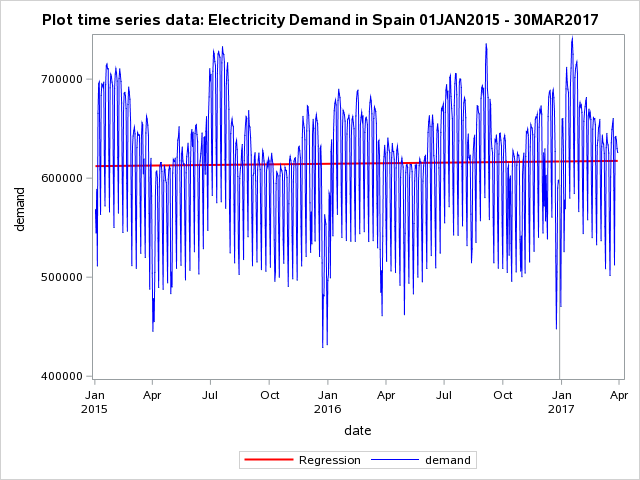

In [8]:


title "Plot time series data: Electricity Demand in Spain 01JAN2015 - 30MAR2017";
PROC SGPLOT DATA=viyalab.edemand;
	reg x=date y=demand / LINEATTRS=(COLOR=RED) MARKERATTRS=(SIZE=2);
	series x=date y=demand / LINEATTRS=(COLOR=BLUE THICKNESS=0.25);
	refline &train_date / axis=x;
RUN;
title;


In [9]:
DATA viyalab.edemand_feat1;
	set viyalab.edemand;
	format idmonth monyy. idQTR yyq.;
	idmonth=intnx('month', date, 0, 'beginning');
	idQTR=intnx('qtr', date, 0, 'beginning');
	year=year(date);
	qtr=qtr(date);
	month=month(date);
	week=week(date);
	weekday=weekday(date);
	
	cos_month=cos(2*constant("pi")*(month-1)/12);
	sin_month=sin(2*constant("pi")*(month-1)/12);
	cos_weekday=cos(2*constant("pi")*(weekday-1)/7);
	sin_weekday=sin(2*constant("pi")*(weekday-1)/7);
	
	target=demand;
	
	/*Target variable lagged once to compute features*/
	feat_lag1=lag1(target);
	feat_lag2=lag2(target);
	feat_lag3=lag3(target);
	feat_lag4=lag4(target);
	feat_lag5=lag5(target);
	feat_lag6=lag6(target);
	feat_lag7=lag7(target);
	
	feat_moveAVE3=mean(of feat_lag1--feat_lag3);
	feat_moveAVE7=mean(of feat_lag1--feat_lag7);
	
	feat_moveSTD3=std(of feat_lag1--feat_lag3);
	feat_moveSTD7=std(of feat_lag1--feat_lag7);
	
	feat_moveMAX3=max(of feat_lag1--feat_lag3);
	feat_moveMAX7=max(of feat_lag1--feat_lag7);
	
	feat_moveMIN3=min(of feat_lag1--feat_lag3);
	feat_moveMIN7=min(of feat_lag1--feat_lag7);
RUN;

In [10]:

DATA viyalab.edemand_feat2;
	set viyalab.edemand_feat1;
	

	feat_moveAVE3_lag7=lag7(feat_moveAVE3);
	feat_moveAVE3_lag14=lag14(feat_moveAVE3);
	feat_moveAVE3_lag30=lag30(feat_moveAVE3);
	feat_moveAVE3_lag60=lag60(feat_moveAVE3);
	feat_moveAVE3_lag120=lag120(feat_moveAVE3);
	feat_moveAVE3_lag240=lag240(feat_moveAVE3);
	feat_moveAVE3_lag365=lag365(feat_moveAVE3);
	
	feat_moveAVE7_lag7=lag7(feat_moveAVE7);
	feat_moveAVE7_lag14=lag14(feat_moveAVE7);
	feat_moveAVE7_lag30=lag30(feat_moveAVE7);
	feat_moveAVE7_lag60=lag60(feat_moveAVE7);
	feat_moveAVE7_lag120=lag120(feat_moveAVE7);
	feat_moveAVE7_lag240=lag240(feat_moveAVE7);
	feat_moveAVE7_lag365=lag365(feat_moveAVE7);
RUN;


PROC CONTENTS DATA=viyalab.edemand_feat2 OUT=MD NOPRINT;
RUN;

title "Initial set of features";
PROC SQL;
	select NAME into: eda_features separated by  " " from md where NAME contains "feat";
QUIT;

Variable Name
feat_lag1
feat_lag2
feat_lag3
feat_lag4
feat_lag5
feat_lag6
feat_lag7
feat_moveAVE3
feat_moveAVE7
feat_moveAVE3_lag7


## 2. EDA


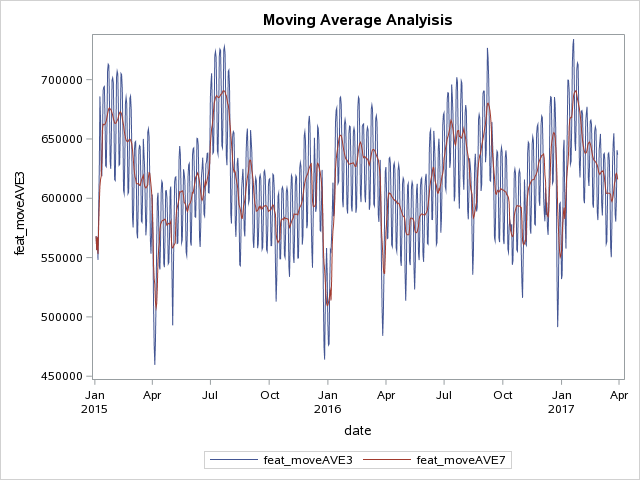

In [11]:

PROC SQL;
	create table agg_monthly_edemand AS
		select idmonth, sum(demand) as demand, avg(demand) as demand_avg, std(demand) as demand_std
		from viyalab.edemand_feat1
		where idmonth<=&fore_date
		group by idmonth
		order by idmonth;
	create table agg_qtr_edemand AS
		select idqtr, qtr, sum(demand) as demand, avg(demand) as demand_avg, std(demand) as demand_std
		from viyalab.edemand_feat1
		where idmonth<=&fore_date
		group by idqtr, qtr
		order by idqtr;
QUIT;

Title "Moving Average Analyisis";
PROC SGPLOT DATA=viyalab.edemand_feat2;
	series x=date y=feat_moveAVE3;
	series x=date y=feat_moveAVE7;
RUN;
title;

It can be seen that the electricity demand is a very complex forecasting problem with several seasonality patterns, and a complex trend-cycle relationship. Moreover it is deeply affected by external variables such us weather in the short term and economic cycle in the long run. However, it is a good starting point to evaluate a general way of performing time series forecasting with neural networks.


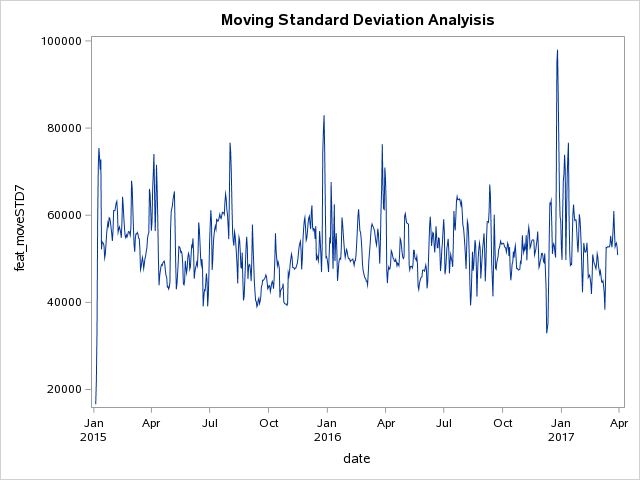

In [12]:
Title "Moving Standard Deviation Analyisis";
PROC SGPLOT DATA=viyalab.edemand_feat2;
	series x=date y=feat_moveSTD7;
RUN;
title;

Sadly, standard deviation varies with time, it will make very hard to fit an ARIMA model, because homocedasticity is one of its main assumptions. Moreover, there is no clear changing pattern in variance, so a GARCH will give an improvement uppon ARIMA, but may yield not sufficiently good results. Not accouting the difficulty in fiting this kind of models


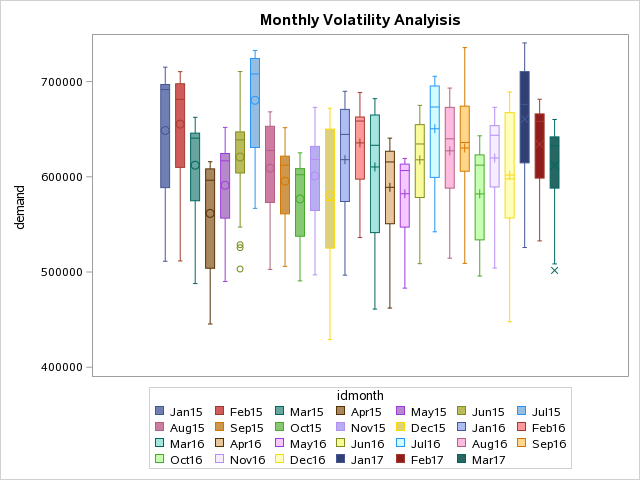

In [13]:
Title "Monthly Volatility Analyisis";
PROC SGPLOT DATA=viyalab.edemand_feat1;
	vbox demand / group=idmonth;
RUN;


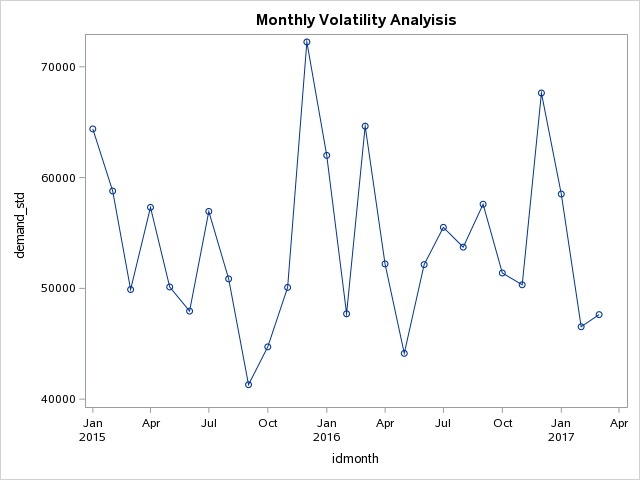

In [14]:
PROC SGPLOT DATA=agg_monthly_edemand;
	series x=idmonth y=demand_std / MARKERS;
RUN;
title;


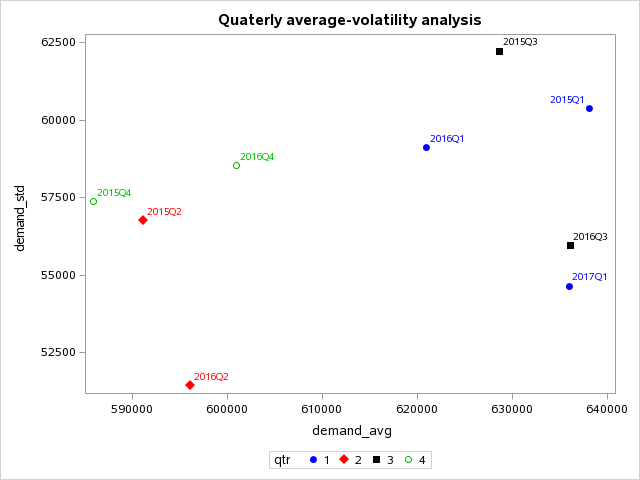

In [15]:

ods graphics on / imagemap;
DATA myattrmap;
	length MARKERCOLOR $ 9 MARKERSYMBOL $ 15;
	input ID $ value  MARKERCOLOR $ MARKERSYMBOL $;
	datalines;
myid 1 blue CircleFilled
myid 2 red DiamondFilled
myid 3 black SquareFilled
myid 4 darkgreen TriangleDownFilled
;
RUN;

Title "Quaterly average-volatility analysis";
PROC SGPLOT DATA=agg_qtr_edemand dattrmap=myattrmap;
	scatter x=demand_avg y=demand_std / GROUP=QTR attrid=myid TIP=(idqtr) DATALABEL=idqtr/* markerattrs=(symbol=circlefilled)*/;
RUN;
title;

In this diagram, we can confirm that in the same quarter, the main statistics of electricity demand may vary enormously.

## 3. FEATURE SELECTION: GBT

In order to not supply many predictors that only yield noise, a GBT is fitted in order to obtain a variable Importance table.

A GBT is a tree ensemble model that sequentially fits small depth trees (stumps) and computes errors. Then the algorithm weights observations to fit better the dataset but balancing model complexity with regularization parameters L1, and L2. This iterative process is called Boosting and it is carried out until up to a max number of times when convergence is expected to be achieved.

As each small tree select a small number of variables to perform split, the accountancy of this selection is carried out and then most important features can be identified.


### 3.1 Train, Validation and Test Split

In [16]:

DATA viyalab.train viyalab.test;
	set viyalab.edemand_feat2;
	flg_train=(date<=&train_Date);
	if flg_Train then output viyalab.train;
	else output viyalab.test;
RUN;

ods graphics off;
ods exclude all;
ods noresults;
PROC PARTITION DATA=viyalab.train samppct=20 partind;
	by month weekday;
	output out=viyalab.train_split;
RUN;
ods graphics on;
ods exclude none;
ods results;


### 3.2 Gradient Boosted Tree Fit

In [17]:

PROC GRADBOOST DATA=viyalab.train_split intervalbins=8 maxdepth=3 MAXBRANCH=2 MINLEAFSIZE= 25 ntrees=100
		ASSIGNMISSING=NONE
        SEED=123; 
	input &eda_features / level=interval;
	target target / level=interval;
	partition rolevar=_PartInd_(train='0' validate='1');
	  /*autotune ...*/
    ods select FitStatistics VariableImportance;
	ods output FitStatistics=gbmFit; 
	ods output VariableImportance=varimp;
RUN;


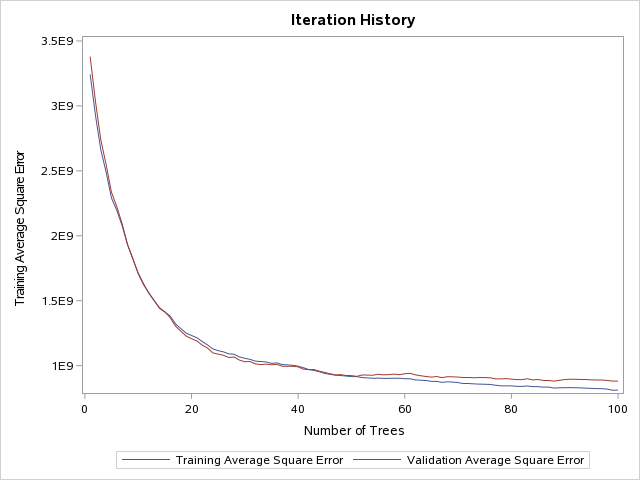

In [18]:

title "Iteration History";
PROC SGPLOT DATA=gbmFit;
	series x=Trees y=ASETrain;
	series x=Trees y=ASEValid;
RUN;
title;


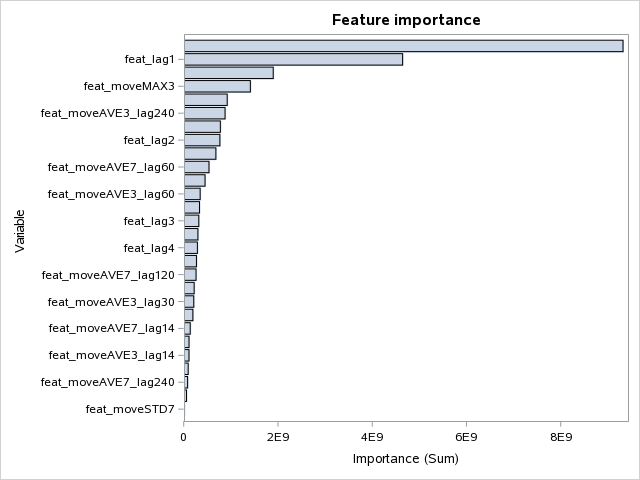

In [19]:
title "Feature importance";
PROC SGPLOT DATA=varimp;
	hbar Variable / response=Importance CATEGORYORDER=RESPDESC;
RUN;

In [20]:
PROC SQL OUTOBS=20;
	select variable into: imp_features separated by " " from varimp;
QUIT;
title;

Variable
feat_lag7
feat_lag1
feat_moveAVE3_lag120
feat_moveMAX3
feat_moveSTD3
feat_moveAVE3_lag240
feat_lag5
feat_lag2
feat_moveAVE3_lag7
feat_moveAVE7_lag60


In [21]:
/*Final Feature Selection*/
DATA _NULL_;
	LENGTH  features $1000.;
	imp_Features="&imp_features";
	features=catx(" ", imp_Features, "cos_month", "sin_month", "cos_weekday", "sin_weekday");
	call SYMPUTX("features", features);
RUN;
%PUT &features;

## 4. MODEL BUILDING: MULTILAYER PERCEPTRON (MLP)

A MLP is the simplest neural net architecture. It has an input layer as features, and some hidden layers, then an output layer that yields the predicted value. The kind of MLP that SAS Viya and VDMML implements only allows to set an output layer with one unit and perform single regression, but more comprehensive frameworks, like SAS Enterprise Miner in SAS9.4 or Scikit Learn in Python can provide a MLP to perform multiple regression, which is very interesting in forecasting, because each output unit is the t-steps ahead forecast.

Eeach hidden unit may be composed of several neurons, and every neuron (or unit) from a layer is connected to every neuron in the next layer, but not to the neurons in the same layer. The number of neurons in a every layer may vary as well as the activation function type (in this experiment than is used and data is automatically standardized by PROC NNET).

Therefore the objective is to fit a MLP with the correct number of hidden layers (K), units per layer(p[k]) and regularization parameters L1 and L2. The K and p[k] controls the NN ability to fit better the train data, but L1 and L2 parameters perform shrinkage in order to avoid overfitting.

In order to keep things simple (remember that this is an demonstration) a one hidden layer MLP is considered. We are aware that given the number of features, the restrained MLP architecture, and the scarce data available, some patterns will not be properly catched, but we want to test how it will perform.

### 4.1 Single Hidden Layer MLP Fit

A sinle hidden layer MLP with 3 neurons will be computed, usually, a MLP is fitted several times with different initialization weigths an biases (MLP parameters), however, in these first iterations, only one training will be performed.

In [22]:
title1 "1 Hidden Layer 3 units";
PROC NNET DATA=viyalab.train_split STANDARDIZE=MIDRANGE;
	architecture  MLP DIRECT;
	optimization algorithm=LBFGS maxiter=100 REGL1=0.1 REGL2=0.1;
	hidden 3; 
	input &features / level=interval;
	target target / level=interval;
	partition rolevar=_partind_(train='0' validate='1');
	train OUTMODEL=viyalab.NN_model_1 NUMTRIES=1;
	score OUT=viyalab.train_scored_1 COPYVARS=(date year qtr month weekday target _PartInd_);
	ods output OptIterHistory=iterhist_1;
RUN;


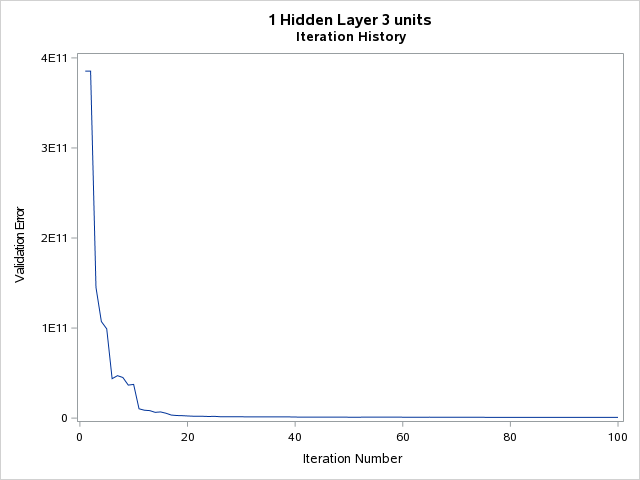

In [23]:
title2 "Iteration History";
PROC SGPLOT DATA=iterhist_1;
	series x=Progress y=ValidError;
RUN;

Iteration history shows that the fiting process converged and there is no noise.


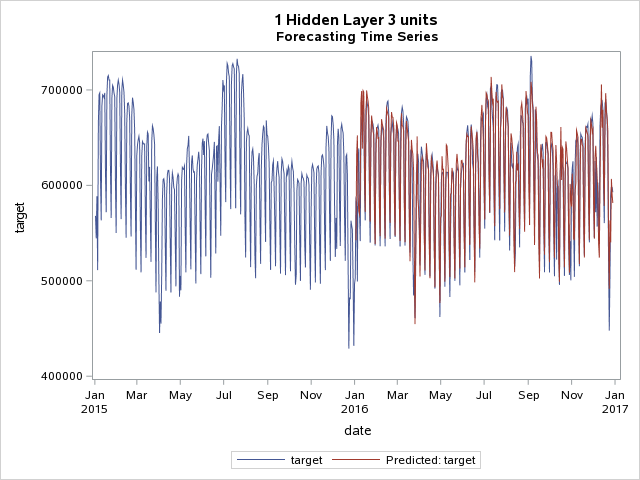

In [24]:
title2 "Forecasting Time Series";
PROC SGPLOT DATA=viyalab.train_scored_1;
	series x=date y=target;
	series x=date y=P_target;
RUN;


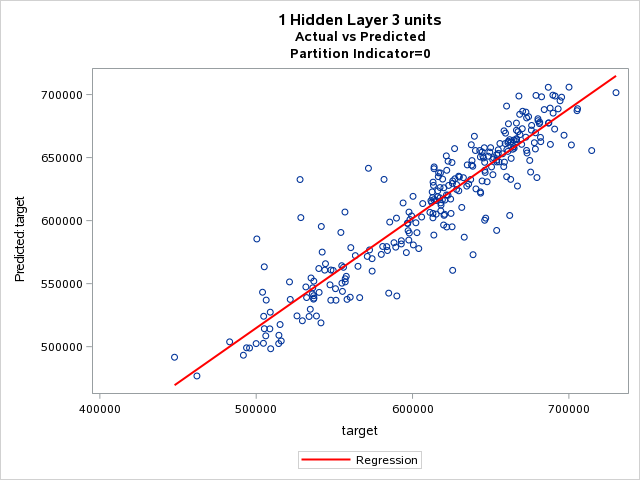
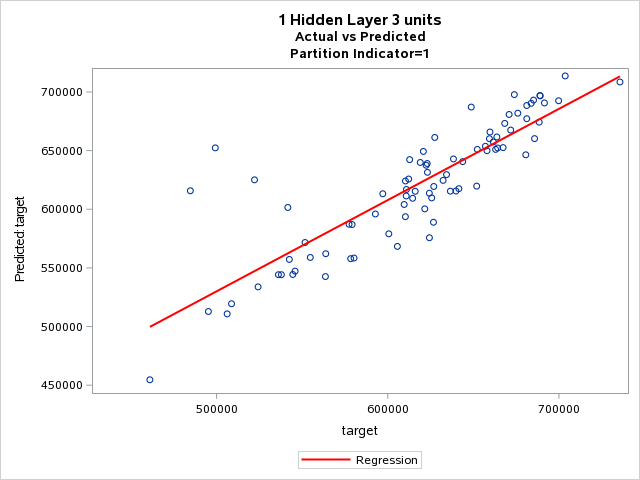

In [25]:
title2 "Actual vs Predicted";
PROC SGPLOT DATA=viyalab.train_scored_1;
	by _PartInd_;
	reg x=target y=P_target / LINEATTRS=(COLOR=RED);
RUN;
title1;title2;

In [26]:

title1 "1 Hidden Layer 12 units";
PROC NNET DATA=viyalab.train_split STANDARDIZE=MIDRANGE;
	architecture  MLP DIRECT;
	optimization algorithm=LBFGS maxiter=100 REGL1=0.1 REGL2=0.1;
	hidden 12; 
	input &features / level=interval;
	target target / level=interval;
	partition rolevar=_partind_(train='0' validate='1');
	train OUTMODEL=viyalab.NN_model_2 NUMTRIES=1;
	score OUT=viyalab.train_scored_2 COPYVARS=(date year qtr month weekday target _PartInd_);
	ods output OptIterHistory=iterhist_2;
RUN;


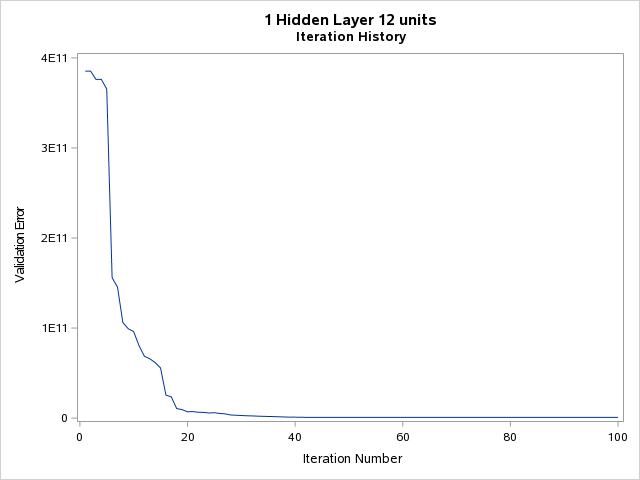

In [27]:

title2 "Iteration History";
PROC SGPLOT DATA=iterhist_2;
	series x=Progress y=ValidError;
RUN;

Convergence is achieved, but some noise appears, it is clear that increasing the number of neurons keeping the regularization parameters L1 and L2 fixed leads to overfitting and unstable behaviour.


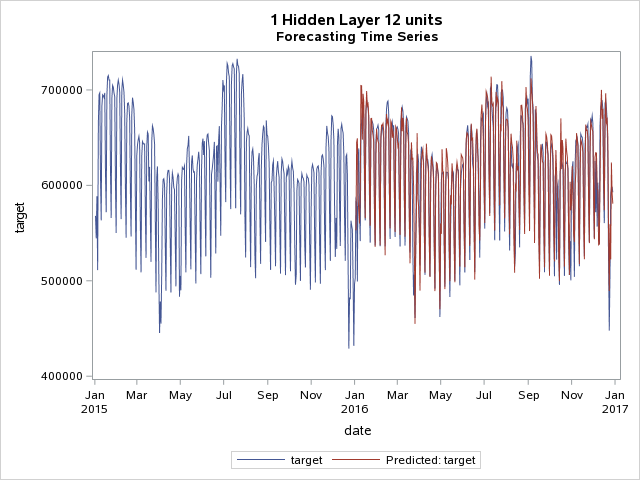

In [28]:
title2 "Forecasting Time Series";
PROC SGPLOT DATA=viyalab.train_scored_2;
	series x=date y=target;
	series x=date y=P_target;
RUN;


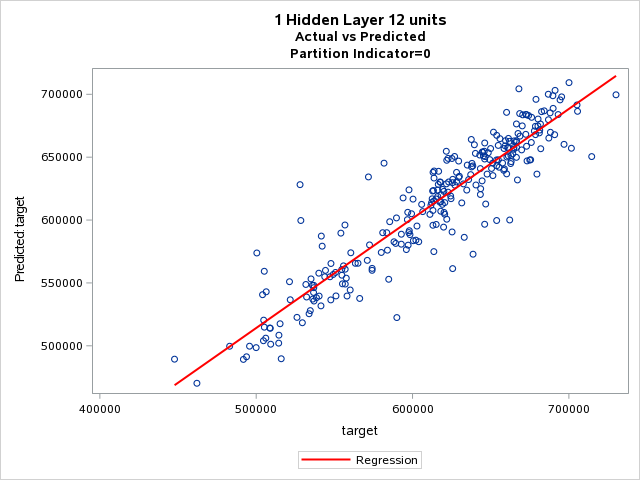
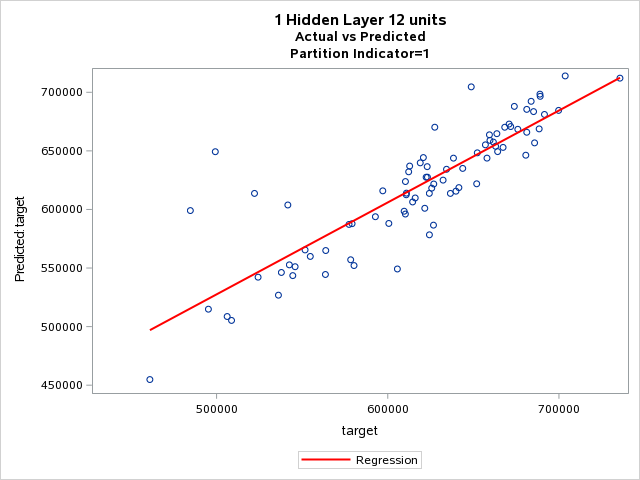

In [29]:
title2 "Actual vs Predicted";
PROC SGPLOT DATA=viyalab.train_scored_2;
	by _PartInd_;
	reg x=target y=P_target / LINEATTRS=(COLOR=RED);
RUN;
title1;title2;

### 4.2 Hyperparameter tuning GA Algo: 1 hidden layer MLP

**General Hyperparameter tuning approach: Cross Validation**
The process of hyperparameter tuning is frequently tackled by a cross-validation (CV) algorithm. The data scientist constructs a grid of hyperparameters (a combination of values for each hyperparameter based on her/his previous knowledge), and then each combination (each grid item) is fitted using CV, therefore each one yields a CV error. Finally, CV errors from each set of hyperparameters is compared and a set of hyperparameters is chosen.

**Hyperparameter tuning with (Simple) Genetic Algorithm (GA):**

With a GA (Genetic Algorithm) instead of providing a grid, some boundaries are delivered to the optimization algorithm and it will search in the given hyperparameter space to (hopefully) yield the optimal set of hyperparameters. Let's explain how this is achieved:

A GA is an optimization algorithm, so it tries to look for a set of inputs values that yields de min error (or max accuracy). When used in hyperparameter tuning, the input of the GA optimization algorithm are the hyperparameters (for example , number of hidden layers and number of activation units per hidden layer when computing a MLP)

The algorithm needs to define a search space so boundaries and initial guess to inputs (hyperparameters) are given, then the algorithm tries to locally search an optimal solution by evaluating different configurations (sets of hypermeters or inputs values). The search is not random as it follows an strategy that resembles Darwin’s Theory of Evolution (in a very simple way)

** GA local search strategy**
The search strategy starts with an initial set of inputs (hyperparameters). In a GA, a set of inputs is called a configuration and a set of configurations is defined as a  population. Then each configuration is assessed using CV (a model is fit with the hyperparameters defined by this population and CV error is computed). 

Best configurations are the ones that are more suitable, so they have better changes to "reproduce", moreover, those better performant configurations, carry some characteristics that make them better, so when they reproduce they pass to the next generation (a new population) a combination of those features that make them so suitable. 



**Reproduction and Mutation: Let's talk about sex.**

How does the reproductive process look like? It is just a function that takes as inputs the parents and yields some children that conserve a combination of features from the parents.

For example, suppose that the optimal number of units in a MLP with one hidden layer is 4 (and suppose that it is global maximum/minimum), and two configurations are chosen as parents, 2 and 5  (those are the ones with lower error in the population). They are good candidates because they are close to the best value possible, so a reproduction function may yield a better candidate, that is closer. Suppose that the reproduction function is average, if we compute the average it is 3.5, which is closer to the actual solution that the parents candidates. (The process is quite more complex, as the input values must be expressed as “genes” or binary variables and the reproduction function it is not a simple computation, but it is a good example).

But we know that a cumbersome issue must be dealt with when hyperparameter tuning is considered: The solution space is very noisy with many  local minimum/maximum, so the algorithm may yield a wrong solution, as a result, it is necessary to further explore the space. This is done by a “mutation” function. This makes sense, as we know that a child is not a perfect combination of his/her parents and some genes may mutate due to errors in chromosomes copy and combination. Therefore, our mutation function will add some randomness to the child generation in order to explore more effectively the solution space.


In [30]:
PROC NNET DATA=viyalab.train_split STANDARDIZE=MIDRANGE;
	architecture  MLP DIRECT;
	optimization algorithm=LBFGS maxiter=100;
	input &features / level=interval;
	target target / level=interval;
	train OUTMODEL=viyalab.NN_model_4 NUMTRIES=3;
	score OUT=viyalab.train_scored_4 COPYVARS=(date year qtr month weekday target _PartInd_);
	autotune KFOLD=10 
	useparameters=custom objective=MSE searchmethod=GA
		/*CV on each configuration*/
		popsize=8 
		maxiter=10 
		maxevals=100 
        tuningparameters=(
        	nhidden(LB=1 UB=1 INIT=1) 
        	nunits1(LB=3 UB=12 INIT=3)
	        regl1(LB=1e-04 UB=1e-01 INIT=1e-03)
	        regl2(LB=1e-04 UB=1e-01 INIT=1e-03)
        )
		EVALHISTORY=TABLE;
        ods select BestConfiguration;
RUN;


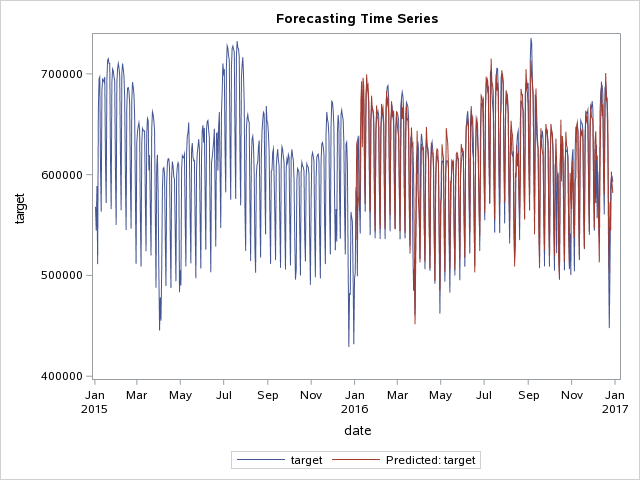

In [31]:
title2 "Forecasting Time Series";
PROC SGPLOT DATA=viyalab.train_scored_4;
	series x=date y=target;
	series x=date y=P_target;
RUN;


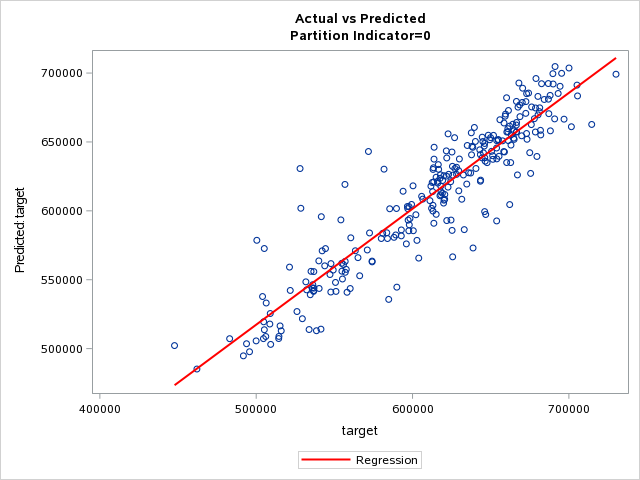
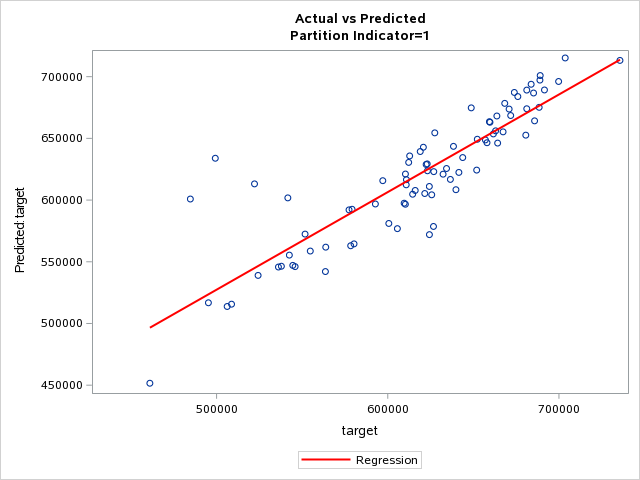

In [32]:
title2 "Actual vs Predicted";
PROC SGPLOT DATA=viyalab.train_scored_4;
	by _PartInd_;
	reg x=target y=P_target / LINEATTRS=(COLOR=RED);
RUN;
title1;title2;

## 5. Test Model

In [33]:
ods graphics off;
ods exclude all;
ods noresults;
%MLP_Forecast(DATA=viyalab.train_scored_4,
	 OUT=viyalab.test_predict, 
	 MODEL=viyalab.NN_model_4, 
	 CASLIB=viyalab, 
	 id=date, 
	 var=target, 
	 interval=day, 
	 lead=&test_period, 
	 train_date=&Train_Date);

DATA viyalab.valid;
	merge viyalab.test_predict viyalab.test (KEEP=date target RENAME=(target=actual));
	by  date;
	flg_Train=(date<=&Train_date);
	resid=actual-forecast;
	ape=abs(resid)/actual;
	sqresid=resid**2;
RUN;

PROC FEDSQL SESSREF=CASAUTO;
	create table ASSESSMENT as
		select flg_Train, avg(ape) as MAPE, avg(sqresid) as RMSE
		from valid
		group by flg_Train;
	quit;
RUN;
ods graphics on;
ods exclude none;
ods results;

flg_Train,MAPE,RMSE
0,0.060729,2236630714.24
1,0.025980,540513966.94

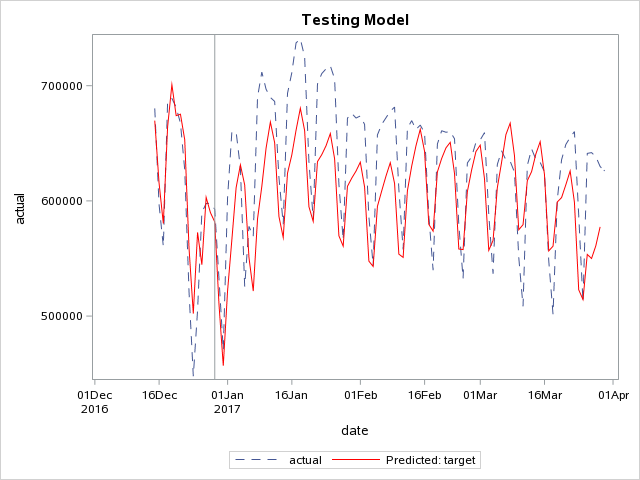

In [34]:

title "Testing Model";
PROC PRINT DATA=viyalab.Assessment;
	id flg_Train;
	var MAPE RMSE;
RUN;
PROC SGPLOT DATA=viyalab.valid;
	where date between intnx('week', &train_date, -2, 'same') and &fore_date;
	series x=date y=Actual / LINEATTRS=(PATTERN=DASH);
	series x=date y=forecast / LINEATTRS=(COLOR=RED);
	refline &train_date / axis=x;
RUN;
title;

## 6. Forecasting

In [35]:
ods graphics off;
ods exclude all;
ods noresults;
PROC NNET DATA=viyalab.edemand_feat2 INMODEL=viyalab.NN_model_4;
	score OUT=viyalab.edemand_scored COPYVARS=(_ALL_);
RUN;

%MLP_Forecast(DATA=viyalab.edemand_scored,
	 OUT=viyalab.edemand_forecast, 
	 MODEL=viyalab.NN_model_4, 
	 CASLIB=viyalab, 
	 id=date, 
	 var=target, 
	 interval=day, 
	 lead=&test_period, 
	 train_date=&fore_date);
ods graphics on;
ods exclude none;
ods results;


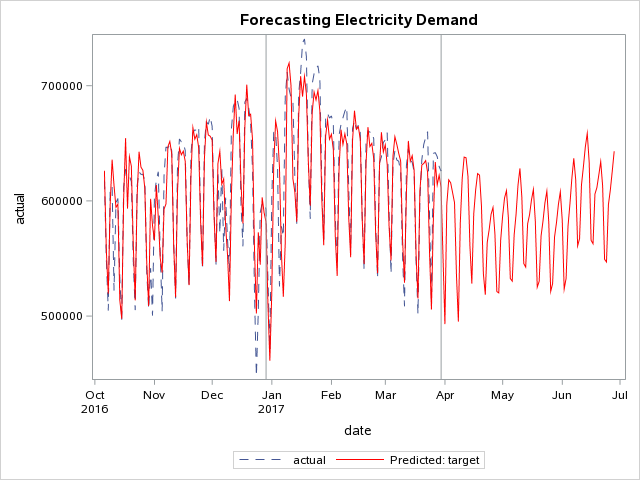

In [37]:
title "Forecasting Electricity Demand";
PROC SGPLOT DATA=viyalab.edemand_forecast;
	where date >= intnx('week', &train_date, -12, 'same');
	series x=date y=actual / LINEATTRS=(PATTERN=DASH);
	series x=date y=forecast / LINEATTRS=(COLOR=RED);
	refline &train_date / axis=x;
	refline &fore_date / axis=x;
RUN;
title;

In conclusion, results are very promising as a daily MAPE (Mean Absolute Percent Error) over 5% is yielded (it depends on the exact combination of hyperparameters choson by GA algorith, I recommend to increase the number of generations and keep track of the results, in order to stabilize the outcome), with a simple approach and a complex time series. In order to achieve further improvements, it is suggested to increase the number of features and further study  the feature selection, in order to be able to build a more complex MLP. On the other hand, several simple MLPs could be stacked to deal with intra-week patterns or rapidly changing trends. Undoubtly, at least one year more of data would be useful, because of missing value generation due to lagged features.

I hope that everyone finds this experiment useful and interesting.

